## Data Analysis 

In [168]:
# Imports 
import pandas as pd
import csv
from datetime import datetime
from datetime import timedelta
import os
import matplotlib.pyplot as plt
import statistics
%matplotlib inline

to download the data and read about the formats of the file go to
http://web.mta.info/developers/turnstile.html

### Functions Used

#### function to read the data as a list of lists

In [2]:
def read_data(path_totextfile):
    with open(path_totextfile, "r") as t_data:  
        next(t_data)                               # iterating each line
        reader = csv.reader(x.replace('\0', '') for x in t_data) # replacing the byte type object with '', if present in the file
        my_list = [[ cell.strip() for cell in row ] for row in reader] # storing as list of list
        i = len(my_list)   # number of rows in the datafile
    return my_list, i

#### Formatting the data prior to 10/18/14, with key as the first 3 unique identifers and value represents the list as per date

In [3]:
# creating the variable as per the pattern of repetition in the data(prior 10/18/14)
c = [3, 8, 13, 18, 23 ,28, 33, 38]

# Formating the data and creating a dictionary 
def format_data(path_totextfile):
    my_hash={}
    the_list, rowcount=read_data(path_totextfile)   # reading the data
    for row in the_list: 
        key = tuple(row[0:3])   # first 3 unique values
        for j in range(len(c)):  # storing the rest of the attributes as values
            if j == 7:
                val = row[c[j]:]
                # check if the key, val exists
                try:
                    my_hash[key].append(val)
                except:
                    my_hash[key] = [val]
            else:
                val = row[c[j]:c[j+1]]
                # check if the key, val exists
                try:
                    my_hash[key].append(val)
                except:
                    my_hash[key] = [val]        
    return my_hash

#### Formatting the data with key state code and date for the year 2013

In [4]:
def format_stdate(my_hash):
    hash_data = {}
    for key, value in my_hash.items():
        val= []
        for v in value:
            if len(v)>0:
                if v[0][6:] == '13': # keeping dates only for the year '2013'
                    k=key+(v[0],)
                    try:
                        hash_data[k].append(v[1:])
                    except:
                        hash_data[k]=[v[1:]]
                    # as '00:00:00' represents the last and first entry of a day therefore, diving it as two different
                    # time values '00:00:00' and '23:59:59'
                    if (v[1]=='00:00:00'): 
                        cop=v
                        #using datetime function to minus one day and replace time value with '23:59:59'
                        date=datetime.strftime((datetime.strptime(v[0],"%m-%d-%y")-timedelta(days=1)).date(),"%m-%d-%y")
                        k=key+(date,)
                        cop[1]="23:59:59"
                        try:
                            hash_data[k].append(cop[1:])
                        except:
                            hash_data[k]=[cop[1:]]
    return hash_data

#### Formatting the data with key state code and date for Q3 in 2013

In [5]:
def format_stdateQ3(my_hash):
    hash_data = {}
    for key, value in my_hash.items():
        val= []
        for v in value:
            if len(v)>0:
                if v[0][:2] == '07' or v[0][:2] == '08' or v[0][:2] == '09': # keeping dates in the third quantile only
                    k=key+(v[0],)
                    try:
                        hash_data[k].append(v[1:])
                    except:
                        hash_data[k]=[v[1:]]
                    # as '00:00:00' represents the last and first entry of a day therefore, diving it as two different
                    # time values '00:00:00' and '23:59:59'
                    if (v[1]=='00:00:00'): 
                        cop=v
                        #using datetime function to minus one day and replace time value with '23:59:59'
                        date=datetime.strftime((datetime.strptime(v[0],"%m-%d-%y")-timedelta(days=1)).date(),"%m-%d-%y")
                        k=key+(date,)
                        cop[1]="23:59:59"
                        try:
                            hash_data[k].append(cop[1:])
                        except:
                            hash_data[k]=[cop[1:]]
    return hash_data

#### Reading the station key provided as a dataframe

In [6]:
station_key = pd.read_csv('Remote-Booth-Station.csv')

#### changing the station using the key provided; (I have named the unknown Control Area codes to station name: ''Unknown'').

In [7]:
def chnge_stname(hash_d):
    hash_data2 = {}
    for key, value in hash_d.items():
        key_list= list(key)
        # all station area code not present in the key provided are named as 'unknown' stations
        try:
            station_name = station_key.Station[station_key.Booth == key_list[0]].values[0]
        except:
            station_name = 'Unknown'
        # combining the values for a particular station
        try:
            hash_data2[tuple([station_name, key_list[2], key_list[3]])]= (hash_d[key] + 
                                                                          hash_data2[tuple([station_name, key_list[2], key_list[3]])])
        except:
            hash_data2[tuple([station_name, key_list[2], key_list[3]])] = hash_d[key]
    return hash_data2

#### Creating a function for changing the station name, also the turntiles associated with each station

In [8]:
def chnge_stname2(hash_d):
    hash_data2 = {}
    for key, value in hash_d.items():
        key_list= list(key)
        # all station area code not present in the key provided are named as 'unknown' stations
        try:
            station_name = station_key.Station[station_key.Booth == key_list[0]].values[0]
        except:
            station_name = 'Unknown'
            
        hash_data2[tuple([station_name, key_list[1], key_list[2], key_list[3]])] = hash_d[key]
    
    return hash_data2

#### creating a entry and exit dictionary with key as station name and date, with value as the number of entries and exit on that day of that particular station

In [9]:
def entry_exit_dict(dict_stnname):
    entry_dict = {}
    exit_dict = {}
    for key, value in dict_stnname.items():
        entry = 0
        exit = 0
        k_list = list(key)
    
        # Entry values
        # if the first entry value is less than the last entry value therefore, the station was active in that day
        # Also, that the audit was scheduled reguarly without disturbing the count
        if int(value[-1][2]) >= int(value[0][2]):
            entry = int(value[-1][2])- int(value[0][2])
        else:
        # But, if the audit is performed by closing the door, and resetting the count, then we calculate the 
        # number of entries as the sum of final count before closing - initial count and count after restting - final count
            for i in range(len(value)-1):
                if int(value[i][2]) > int(value[i+1][2]):
                    ent1 = int(value[i][2]) - int(value[0][2])
                    ent2 = int(value[-1][2]) - int(value[i+1][2])
            entry = ent1+ent2
    
        # exit value
        # same technique is used for calculation of exit as well.
        if int(value[-1][3]) >= int(value[0][3]):
            exit = int(value[-1][3])- int(value[0][3])
        else:
            for i in range(len(value)-1):
                if int(value[i][3]) > int(value[i+1][3]):
                    ext1 = int(value[i][3]) - int(value[0][3])
                    ext2 = int(value[-1][3]) - int(value[i+1][3])
            exit = ext1+ext2
     
    # creating entry value dictionary
        try:
            entry_dict[tuple([k_list[0], k_list[2]])] = entry_dict[tuple([k_list[0], k_list[2]])] + entry
        except:
            entry_dict[tuple([k_list[0], k_list[2]])] =  entry
    
    # creating exit value dictionary
        try:
            exit_dict[tuple([k_list[0], k_list[2]])] = exit_dict[tuple([k_list[0], k_list[2]])] + exit
        except:
            exit_dict[tuple([k_list[0], k_list[2]])] =  exit
    
    return entry_dict, exit_dict


#### the function is same as above, but this time, turntiles numbers are also preserved

In [10]:
def ent_ext_dict2(dict_stnname):
    entry_dict = {}
    exit_dict = {}
    for key, value in dict_stnname.items():
        entry = 0
        exit = 0
        k_list = list(key)
    
        # entry value
        if int(value[-1][2]) >= int(value[0][2]):
            entry = int(value[-1][2])- int(value[0][2])
        else:
            for i in range(len(value)-1):
                if int(value[i][2]) > int(value[i+1][2]):
                    ent1 = int(value[i][2]) - int(value[0][2])
                    ent2 = int(value[-1][2]) - int(value[i+1][2])
            entry = ent1+ent2
    
        # exit value
        if int(value[-1][3]) >= int(value[0][3]):
            exit = int(value[-1][3])- int(value[0][3])
        else:
            for i in range(len(value)-1):
                if int(value[i][3]) > int(value[i+1][3]):
                    ext1 = int(value[i][3]) - int(value[0][3])
                    ext2 = int(value[-1][3]) - int(value[i+1][3])
            exit = ext1+ext2
     
    # creating entry value dictionary
        try:
            entry_dict[tuple([k_list[0], k_list[1], k_list[3]])] = entry_dict[tuple([k_list[0], k_list[1], k_list[3]])] + entry
        except:
            entry_dict[tuple([k_list[0], k_list[1], k_list[3]])] =  entry
    
    # creating exit value dictionary
        try:
            exit_dict[tuple([k_list[0], k_list[1], k_list[3]])] = exit_dict[tuple([k_list[0], k_list[1], k_list[3]])] + exit
        except:
            exit_dict[tuple([k_list[0], k_list[1], k_list[3]])] =  exit
    
    return entry_dict, exit_dict


#### Funciton to sort the keys of the dictionary

In [11]:
def sortdict(d):
    for key in sorted(d): yield d[key]

### Question 1.) Which station has the most number of units?

I have taken the latest dataset to calculate the number of units, as all datasets have the same number of units for a station, the data is saved as text file

In [233]:
# reading the data in a dataframe
df = pd.read_csv("./2sigmadata/turnstile_160507.txt")

In [234]:
# grouping by the station and aggregating the number of units it has
d1 = df.groupby("STATION").agg({"UNIT": pd.Series.nunique})

#### Solution:

In [237]:
# the station with maximum number of units
print("The station with maximum number of units is '%s'" %d1['UNIT'].idxmax())

The station with maximum number of units is '23 ST'


### Question 2.) What is the total number of entries & exits across the subway system for August 1, 2013?

As the question requires the data for 1st August 2013 only, therefore the corresponding dataset is stored in local directory.

The data is quite messy, therefore, reading it as csv will be tough to work with, therefore we read each line of the data a list. I observe that first 3 entries are unique, while the rest are entries re-occur in pattern after every 5 entries representing the date, time, audit type, entries and exits. I have created a fuction for the above task which is defined above.

In [238]:
# creating the dictionary
data_dict = format_data("./2sigmadata/turnstile_130803.txt")

While the data consist of entries for other days as well, therefore keeping only entries for august 1. Also, I observed that the entry "00:00:00" on august 2, actually represents the end of day entry of august1. Therefore, I kept that entry and converted it to '23:59:59' on august 1, 2013 for better usage.

In [239]:
august1_dict = {}
for key, value in data_dict.items():
    val = []
    for v in value:
        if len(v) > 0:
            if v[0] == '08-01-13' or (v[0] == '08-02-13' and v[1] == '00:00:00'):
                val.append(v)
                august1_dict[key] = val

#### Calculating the entries and exits for all turntiles on 1st August

I observed that door closes on some days and the entries and exits counts is restarted, therefore, I have incorporated this element in my code. If the first entry is larger than the last entry, then after the audit the count is resetted, therefore the calculation for entry and exit count should be:

count before the audit - initial count + (final count of the day- 1st count after the resetting the meter)

In [240]:
entry = 0
exit = 0
for key, value in august1_dict.items():
    # regular days
    if float(value[-1][4]) > float(value[0][4]):
        entry += float(value[-1][3])- float(value[0][3])
        exit +=  float(value[-1][4])- float(value[0][4])
    
    # days on which the door closes, the count restarts
    if float(value[-1][4]) < float(value[0][4]):
        for i in range(len(value)-1):
            if float(value[i][4]) > float(value[i+1][4]):
                ent1 = float(value[i][3]) - float(value[0][3])
                ext1 = float(value[i][4]) - float(value[0][4])
                ent2 = float(value[-1][3]) - float(value[i+1][3])
                ext2 = float(value[-1][4]) - float(value[i+1][4])
        entry += ent1 + ent2
        exit += ext1 + ext2

### Solution:

In [242]:
print("The total entries are: %i and total exits are: %i" %(entry, exit))

The total entries are: 5374439 and total exits are: 4248156


### Question 3.) Let’s define the busy-ness as sum of entry & exit count. What station was the busiest on August 1, 2013? What turnstile was the busiest on that date?

In [244]:
# changing the area code to station name for better understanding and revoming the scp number as we require just the
# station name and date
august1_st = chnge_stname(format_stdate(august1_dict))

In [245]:
busyness_station = {}   # dictionay to store the value of each station
for key, value in august1_st.items():
    entry = 0
    exit = 0
    busyness = 0
    k_ = list(key)
    # using the same concept that on some days the door closes,so count restarts
    
    # regular days
    if int(value[-1][2]) > int(value[0][2]):
        entry = int(value[-1][2])- int(value[0][2])
        exit =  int(value[-1][3])- int(value[0][3])
        busyness = entry + exit
        
        try:
            busyness_station[k_[0]] = busyness_station[k_[0]] + busyness
        except:
            busyness_station[k_[0]] = busyness
    
    # days on which the count restarts
    if int(value[-1][2]) < int(value[0][2]):
        for i in range(len(value)-1):
            if int(value[i][2]) > int(value[i+1][2]):
                ent1 = int(value[i][2]) - int(value[0][2])
                ext1 = int(value[i][3]) - int(value[0][3])
                ent2 = int(value[-1][2]) - int(value[i+1][2])
                ext2 = int(value[-1][3]) - int(value[i+1][3])
        entry = ent1 + ent2
        exit = ext1 + ext2
        busyness = entry+exit
        
        try:
            busyness_station[k_[0]] = busyness_station[k_[0]] + busyness
        except:
            busyness_station[k_[0]] = busyness

### Solution: 

In [246]:
print("The station with maximum busyness is '%s'" %(max(busyness_station, key=busyness_station.get)))

The station with maximum busyness is '42 ST-PA BUS TE'


### Question 4.) What stations have seen the most usage growth/decline in 2013?

I have stored the entire datasets provided for the year 2013 in the directory and then rather than storing dictionary for each datafile, I will calculate the entry and exit count specific for each station and date (useful in Next question).

In [247]:
# path of the directory and creating a list of files
path = './2sigmadata/2013/'
filedata = [filelist for filelist in os.listdir(path)]

In [248]:
# calculating the entry and exits count for each station on a particular date
final_entry2013 = {}
final_exit2013 = {}
for filename in filedata:
    dict1 = format_data(path + filename)
    dict_st = format_stdate(dict1)
    dict_stname = chnge_stname(dict_st)
    dict_ent, dict_ext = entry_exit_dict(dict_stname)
    final_entry2013.update(dict_ent)
    final_exit2013.update(dict_ext)

Station usage growth/decline is defined as the surge/decline in entry counts on 1st January 2013 vs 31st December 2013
#### There might be some stations which may not have entry for 1st Jan 2013 or 31st December 2013 Reason being, they might be closed for maintenance or they must had been opened at some preceeding date in 2013. while other reasons may exist

Therefore, to counter such a situation we have to find the start and end date on which entry have been made of each station and they calculate the growth/decline. To perform such a task, initially, I have calculated a list of unique station names and then correspondingly another list creating storing all the dates in python-datetime format. Then for each station growth/decline value is calculated

In [249]:
# finding list with unique station names
st_list = []
for key, value in final_entry2013.items():
    k1 = list(key)
    if k1[0] not in st_list:
        st_list.append(k1[0])               

#### Creating list with each element representing a list of all dates to the corresponding station in 'st_list'

In [250]:
date_allst = []
for st_name in st_list:
    date = []
    for key, value in final_entry2013.items():
        k2 = list(key)
        if k2[0] == st_name:
            date.append(datetime.strptime(k2[1],"%m-%d-%y"))
    date_allst.append(date)

Calculating growth/decline as defined above. i.e the difference between the total count on 31st December 2013- 1st January 2013

In [251]:
station_growth = {}
for idx, st_name in enumerate(st_list):
    end_date = datetime.strftime(max(date_allst[idx]).date(),"%m-%d-%y")
    start_date = datetime.strftime(min(date_allst[idx]).date(),"%m-%d-%y")
    station_growth[st_name] = ((final_entry2013[tuple([st_name, end_date])]+final_exit2013[tuple([st_name,end_date])])-
                                (final_entry2013[tuple([st_name, start_date])]+final_exit2013[tuple([st_name,start_date])]))

### Solution:

In [252]:
print("Station with Maximum Growth: '%s'" %(max(station_growth, key=station_growth.get)))

Station with Maximum Growth: '86 ST'


In [254]:
print("Station with Maximum Decline: '%s'" %(min(station_growth, key=station_growth.get)))

Station with Maximum Decline: 'ROCKAWAY PK 116'


### Question 5.) What dates are the least busy? Could you identify days on which stations were not operating at full capacity or closed entirely?

In [255]:
# creating unique list of dates
date_list2013 = []
for key, value in final_entry2013.items():
    k = list(key)
    if k[1] not in date_list2013:
        date_list2013.append(k[1])

date_list2013.remove('12-31-12') # the last day of the year 2012 appears as it contains the value '00:00:00' which 
# corresponds to the first entry of 2013

#### As defined calculating the busyness of each date, as the sum of entry and exit count

In [256]:
date_dict = {}
for date in date_list2013:
    for key, value in final_entry2013.items():
        k = list(key)
        if k[1] == date:
            try:
                date_dict[k[1]] = date_dict[k[1]] + value + final_exit2013[key]
            except:
                date_dict[k[1]] = value + final_exit2013[key]

#### Days on which the stations are closed completely

In [257]:
for key, value in date_dict.items():
    if value == 0:
        print(key)

There are no days on which the all the station is closed entirely

#### I define the least busy days, as the days which have less than or equal to 25% of the traffic of the busiest day

In [258]:
# most busiest day
print(max(date_dict, key=date_dict.get), max(date_dict.values()))

05-16-13 4536190677


#### Therefore, the least busy days are:

In [259]:
least_busy_days = []
for day, value in date_dict.items():
    if value <= (max(date_dict.values())*.25):
        least_busy_days.append(day)

In [260]:
print("Number of least busy days: %i" % (len(least_busy_days)))
print("The days are: %s" %(least_busy_days))

Number of least busy days: 13
The days are: ['05-31-13', '01-25-13', '11-29-13', '04-26-13', '10-11-13', '05-10-13', '01-04-13', '08-23-13', '08-02-13', '03-29-13', '09-20-13', '04-19-13', '03-22-13']


**To find the stations which were not fully operations or closed on certain days, we can check the turntiles for each station and whether they were active or not, for simplication, I have defined functions which are quite similar to the previous functions but, this time they calculate busyness according to turntiles as well**

In [76]:
f_turn_ent2013 = {}
f_turn_ext2013 = {}
for filename in filedata:
    dict1 = format_data(path + filename) # reading and formatting the data
    dict_st = format_stdate(dict1)       # changing the format with date, and accounting of days only in 2013
    dict_stname = chnge_stname2(dict_st) # changing the station name
    dict_ent, dict_ext = ent_ext_dict2(dict_stname)  # calculating the total entry and exit values
    # updating the entry dictionary i.e adding pair of keys and values
    f_turn_ent2013.update(dict_ent) 
    f_turn_ext2013.update(dict_ext)

In [77]:
not_fuloprt = []
for key, value in f_turn_ent2013.items():
    k = list(key)
    if (value + f_turn_ext2013[key]) == 0: # the station is inactive if the total count of entry and exit is zero
        not_fuloprt.append(k[2])

### Solution:
#### Days on which the stations were not fully operational

In [81]:
print("Number of days stations were not fully operations days: %i" % (len(set(not_fuloprt))))
print("The days are: %s" %(set(not_fuloprt)))

Number of days stations were not fully operations days: 222
The days are: {'10-29-13', '01-23-13', '06-23-13', '05-03-13', '03-20-13', '09-22-13', '06-30-13', '06-14-13', '05-10-13', '10-19-13', '02-18-13', '11-02-13', '09-29-13', '07-26-13', '03-11-13', '11-22-13', '02-23-13', '03-23-13', '04-17-13', '07-14-13', '03-09-13', '09-05-13', '04-16-13', '08-29-13', '01-17-13', '04-21-13', '10-06-13', '05-26-13', '01-13-13', '05-11-13', '02-14-13', '07-03-13', '07-12-13', '04-10-13', '08-30-13', '01-19-13', '03-29-13', '03-30-13', '10-27-13', '12-13-13', '01-30-13', '06-18-13', '01-21-13', '12-29-13', '08-15-13', '07-25-13', '01-05-13', '04-11-13', '03-16-13', '01-14-13', '05-05-13', '03-10-13', '09-20-13', '02-21-13', '03-01-13', '01-03-13', '11-03-13', '01-02-13', '08-09-13', '05-17-13', '04-03-13', '10-13-13', '12-20-13', '02-08-13', '08-08-13', '11-09-13', '08-02-13', '01-16-13', '02-02-13', '08-04-13', '02-28-13', '04-13-13', '01-08-13', '02-27-13', '03-21-13', '04-15-13', '12-21-13', '

## Data Visualization

### Question 1.) Plot the daily row counts for data files in Q3 2013.

In [12]:
# Path to the directory and creating a list of files in that directory
path1 = './2sigmadata/Q3/'
filedata1 = [filelist for filelist in os.listdir(path1)]

In [13]:
tot_rowcounts = []
for files in filedata1:
    datafile, rowcount = read_data(path1+files)
    tot_rowcounts.append(rowcount)
len(tot_rowcounts)

14

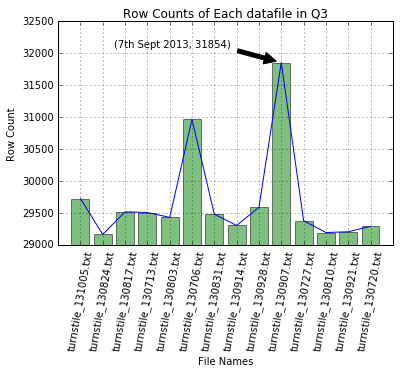

In [186]:
# plotting the row count for each data file in Q3
plt.plot(range(1,15), tot_rowcounts)
plt.bar(range(1,15), tot_rowcounts, alpha=0.5, align='center', color='g')
plt.ylabel("Row Count")
plt.xlabel("File Names")
plt.axis([ 0, 15, 29000, 32500])
plt.title("Row Counts of Each datafile in Q3")
plt.xticks(range(1,15), filedata1, rotation = 80)
plt.annotate('(7th Sept 2013, 31854)', xy=(10, 31854), xytext=(2.5, 32100),
            arrowprops=dict(facecolor='black', shrink=0.1))
plt.grid(True)
plt.show()

### Question 2.) Plot the daily total number of entries & exits across the system for Q3 2013.

In [16]:
# creating a dictionary of exit and entry count( as before done for 2013) but this one is for Q3 only
final_entryQ3 = {}
final_exitQ3 = {}
for filename in filedata1:
    dict1 = format_data(path1 + filename)
    dict_st = format_stdateQ3(dict1)
    dict_stname = chnge_stname(dict_st)
    dict_ent, dict_ext = entry_exit_dict(dict_stname)
    final_entryQ3.update(dict_ent)
    final_exitQ3.update(dict_ext)

In [17]:
# creating unique list of dates
date_list = []
for key, value in final_entryQ3.items():
    k = list(key)
    if k[1] not in date_list:
        date_list.append(k[1])

date_list.remove('06-30-13')  # the day appears because of the entry of '00:00:00'

In [28]:
# Entry and exit count on each date
date_entry_dict = {}
date_exit_dict = {}

for date in date_list: 
    for key, value in final_entryQ3.items():
        k = list(key)
        #for each date in the date list
        if k[1] == date:
            #adding the entries on that date
            try:
                date_entry_dict[k[1]] = date_entry_dict[k[1]] + value
            except:
                date_entry_dict[k[1]] = value
    # adding the exit count on that date
    for key1, val in final_exitQ3.items():
        k1 = list(key1)
        if k1[1] == date:
            try:
                date_exit_dict[k1[1]] = date_exit_dict[k1[1]] + val
            except:
                date_exit_dict[k1[1]] = val

As the keys in a dictionary does not sort the keys iteself, but we can sort the list of the keys according to the date, and store the value to plot

**Sorting the values**

In [30]:
# value in sorted form according to the date
values = []
for val in sortdict(date_entry_dict):
    values.append(val)

In [33]:
# value in sorted form according to the date
values2 = []
for val in sortdict(date_exit_dict):
    values2.append(val)

** Plotting the entry count for each day**

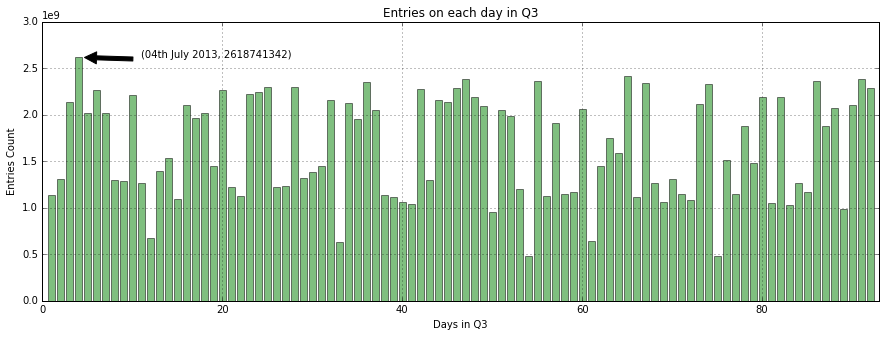

In [185]:
plt.figure(figsize=(15,5))
plt.bar(range(1,93), values, alpha=0.5, align='center', color='g')
plt.ylabel("Entries Count")
plt.xlabel("Days in Q3")
plt.axis([ 0, 93, 0, 3000000000])
plt.title("Entries on each day in Q3")
plt.annotate('(04th July 2013, 2618741342)', xy=(4, 2618741342), xytext=(11,2618741342),
            arrowprops=dict(facecolor='black', shrink=0.1))
plt.grid(True)
plt.show()

** Plotting the exit counts for each day**

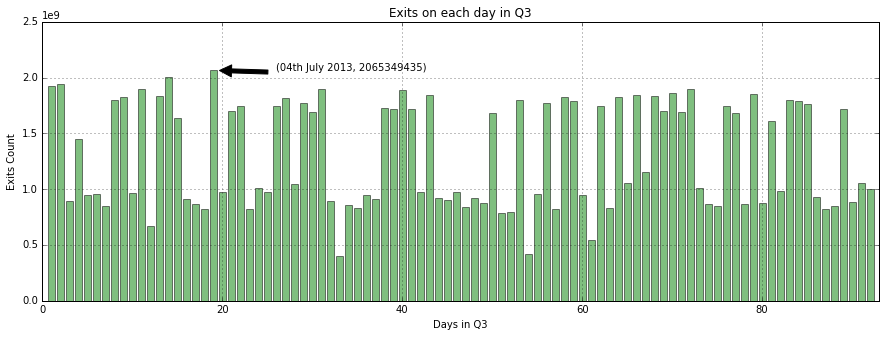

In [184]:
plt.figure(figsize=(15,5)
plt.bar(range(1,93), values2, alpha=0.5, align='center', color='g')
plt.ylabel("Exits Count")
plt.xlabel("Days in Q3")
plt.axis([ 0, 93, 0, 2500000000])
plt.title("Exits on each day in Q3")
plt.annotate('(04th July 2013, 2065349435)', xy=(19, 2065349435), xytext=(26,2065349435),
            arrowprops=dict(facecolor='black', shrink=0.1))
plt.grid(True)
plt.show()

### Question 3.) Plot the mean and standard deviation of the daily total number of entries & exits for each month in Q3 2013 for station 34 ST-PENN STA. 

In [224]:
# keeping entry values for '34 ST-PENN STA'
pennst_entQ3= {}
for key, value in final_entryQ3.items():
    k = list(key)
    if k[0] == '34 ST-PENN STA':
        pennst_entQ3[k[1]] = value

In [ ]:
# keeping exit values for '34 ST-PENN STA'
pennst_extQ3= {}
for key, value in final_exitQ3.items():
    k = list(key)
    if k[0] == '34 ST-PENN STA':
        pennst_extQ3[k[1]] = value

In [156]:
# formatting the data only each month in Q3
pennst_july = []
pennst_aug = []
pennst_sept = []
for key, value in pennst_entQ3.items():
    if key[:2] == '07':
        pennst_july.append(value)
    elif key[:2] == '08':
        pennst_aug.append(value)
    elif key[:2] == '09':
        pennst_sept.append(value)    
        

In [161]:
# calculating the mean for each month
pennst_july_mean = sum(pennst_july)/len(pennst_july)
pennst_aug_mean = sum(pennst_aug)/len(pennst_aug)
pennst_sept_mean = sum(pennst_sept)/len(pennst_sept)
pennst_mean = [pennst_july_mean, pennst_aug_mean, pennst_sept_mean]

In [170]:
# calculating the standard deviation for each month
pennst_july_sd = statistics.stdev(pennst_july)
pennst_aug_sd = statistics.stdev(pennst_aug)
pennst_sept_sd = statistics.stdev(pennst_sept)
pennst_sd = [pennst_july_sd, pennst_aug_sd, pennst_sept_sd]

In [187]:
# formatting the exit data as per each month in Q3 2013
pennst_july2 = []
pennst_aug2 = []
pennst_sept2 = []
for key, value in pennst_extQ3.items():
    if key[:2] == '07':
        pennst_july2.append(value)
    elif key[:2] == '08':
        pennst_aug2.append(value)
    elif key[:2] == '09':
        pennst_sept2.append(value)    

pennst_july_mean2 = sum(pennst_july2)/len(pennst_july2)
pennst_aug_mean2 = sum(pennst_aug2)/len(pennst_aug2)
pennst_sept_mean2 = sum(pennst_sept2)/len(pennst_sept2)
pennst_mean2 = [pennst_july_mean2, pennst_aug_mean2, pennst_sept_mean2]

pennst_july_sd2 = statistics.stdev(pennst_july2)
pennst_aug_sd2 = statistics.stdev(pennst_aug2)
pennst_sept_sd2 = statistics.stdev(pennst_sept2)
pennst_sd2 = [pennst_july_sd, pennst_aug_sd2, pennst_sept_sd2]

** Plotting the standard deviation and mean for each month in Q3 2013**

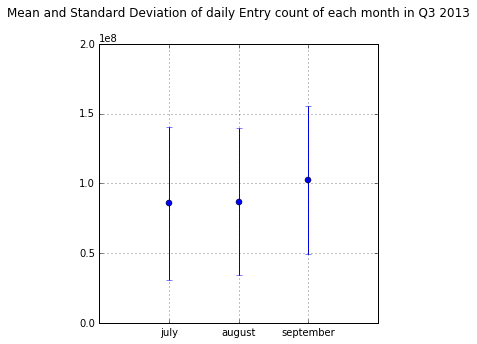

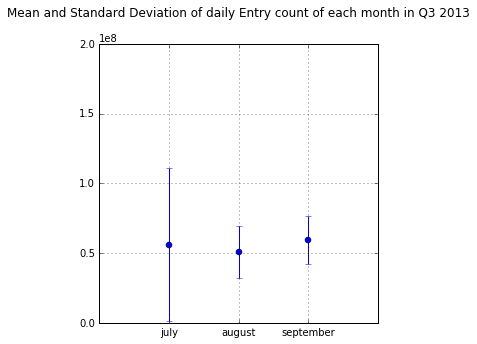

In [262]:
x = [1,2,3]

plt.figure(1, figsize=(5,5))
plt.errorbar(x, pennst_mean, pennst_sd, linestyle='None', marker='o')
plt.xticks(x, ['july', 'august', 'september'])
plt.axis([0,4, 0, 2e8])
plt.title("Mean and Standard Deviation of daily Entry count of each month in Q3 2013", y=1.08)
plt.grid(True)
plt.show()

plt.figure(2, figsize=(5,5))
plt.errorbar(x, pennst_mean2, pennst_sd2, linestyle='None', marker='o')
plt.xticks(x, ['july', 'august', 'september'])
plt.axis([0,4, 0, 2e8])
plt.title("Mean and Standard Deviation of daily Entry count of each month in Q3 2013", y=1.08)
plt.grid(True)
plt.show()

### Question 4.) Plot 25/50/75 percentile of the daily total number of entries & exits for each month in Q3 2013 for station 34 ST-PENN STA.

In [199]:
# combining all the data in a list
entrydata_to_plot = [pennst_july, pennst_aug, pennst_sept]
exitdata_to_plot = [pennst_july2, pennst_aug2, pennst_sept2]

** Plotting the total number of entry and exits for each month in Q3 2013**

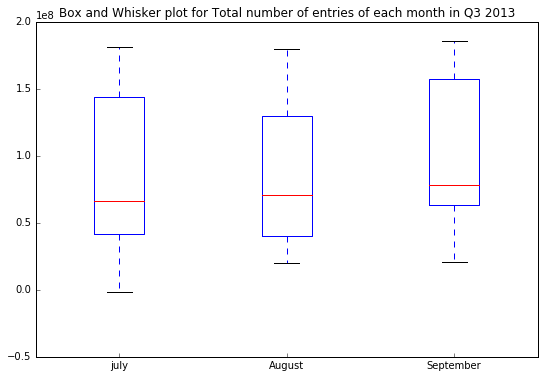

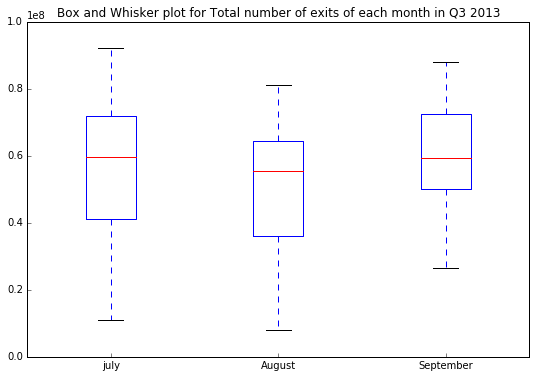

In [217]:
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(entrydata_to_plot)
ax.set_xticklabels(['july', 'August','September'])
ax.set_title("Box and Whisker plot for Total number of entries of each month in Q3 2013")
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()


fig = plt.figure(2, figsize=(9, 6))
ax2 = fig.add_subplot(111)
bp2 = ax2.boxplot(exitdata_to_plot)
ax2.set_xticklabels(['july', 'August','September'])
ax2.set_title("Box and Whisker plot for Total number of exits of each month in Q3 2013")
ax2.get_xaxis().tick_bottom()
ax2.get_yaxis().tick_left()


### Question 5.) Plot the daily number of closed stations and number of stations that were not operating at full capacity in Q3 2013.

In [89]:
# finding the closed stations on each day of Q3 2013
closed_stQ3= {}
for date in date_list:
    for key, value in final_entryQ3.items(): # using the data from the initially calculated entry 
                                             # count for each station on a particular day
        k = list(key)
        if k[1] == date:
            if value + final_exitQ3[key] == 0:
                try:
                    closed_stQ3[k[1]][k[0]] = 1
                except:
                    closed_stQ3[k[1]] = {k[0]:1}

In [117]:
# calculating the number of stations for each day in Q3 2013
closed_stQ3_count = {}
for key, value in closed_stQ3.items():
    closed_stQ3_count[key] = len(value)

# adding the value '0' for dates that do not have any closed stations
for date in date_list:
    if date not in list(closed_stQ3.keys()):
        closed_stQ3_count[date] = 0

In [125]:
# sorting the data according to the date
values3 = []
for val in sortdict(closed_stQ3_count):
    values3.append(val)

** Plotting number of closed stations in Q3**

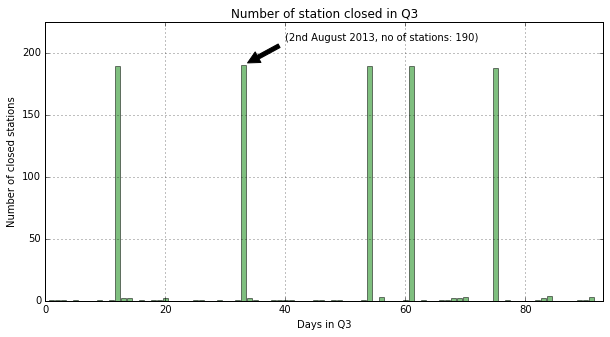

In [182]:
plt.figure(figsize=(10,5))
plt.bar(range(1,93), values3, alpha=0.5, align='center', color='g')
plt.ylabel("Number of closed stations in Q3 2013")
plt.xlabel("Days in Q3")
plt.axis([ 0, 93, 0, 225])
plt.title("Number of station closed in Q3")
plt.annotate('(2nd August 2013, no of stations: 190)', xy=(33, 190), xytext=(40,210),
            arrowprops=dict(facecolor='black', shrink=0.1))
plt.grid(True)
plt.show()

In [40]:
# again calculating the daily entries and exits but here we keep the turntile units of each station as well.
daily_entQ3 = {}
daily_extQ3 = {}
for filename in filedata1:
    dict1 = format_data(path1 + filename)
    dict_st = format_stdateQ3(dict1)
    dict_stname = chnge_stname2(dict_st)
    dict_ent, dict_ext = ent_ext_dict2(dict_stname)
    daily_entQ3.update(dict_ent)
    daily_extQ3.update(dict_ext)

In [66]:
# calculating the stations which had atleast one of their turntiles on working on a particular day
not_fuloprtQ3 = {}
for date in date_list:
    for key, value in daily_entQ3.items():
        k = list(key)
        if k[2] == date:
            if value + daily_extQ3[key] == 0:
                try:
                    not_fuloprtQ3[k[2]][k[0]] = 1
                except:
                    not_fuloprtQ3[k[2]] = {k[0]:1}


In [99]:
# removing the stations which are fully closed on that particular day, which gives only the count of stations which
# were not operating at full capacity
not_fuloprtQ3_count = {}
for key, value in not_fuloprtQ3.items():
    not_fuloprtQ3_count[key] = (len(value) - len(closed_stQ3[key]))

for date in date_list:
    if date not in list(not_fuloprtQ3_count.keys()):
        not_fuloprtQ3_count[date] = 0

In [119]:
# sorting the data according to the date
values4 = []
for val in sortdict(not_fuloprtQ3_count):
    values4.append(val)

**Plotting stations not opertional at full capacity (not including the closed stations) **

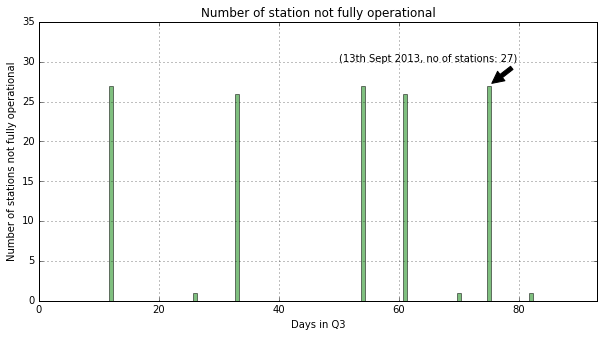

In [183]:
plt.figure(figsize=(10,5))
#plt.plot(range(1,93), list(date_entry_dict.values()))
plt.bar(range(1,93), values4, alpha=0.5, align='center', color='g')
plt.ylabel("Number of stations not fully operational")
plt.xlabel("Days in Q3")
plt.axis([ 0, 93, 0, 35])
plt.title("Number of station not fully operational")
plt.annotate('(13th Sept 2013, no of stations: 27)', xy=(75, 27), xytext=(50,30),
            arrowprops=dict(facecolor='black', shrink=0.1))
plt.grid(True)
plt.show()

###                                                                           Thank You